<a href="https://colab.research.google.com/github/syphaxAouadene/Cours_programmation_concurrente/blob/main/my_first_neural_network_for_handwritten_digit_classification_version_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here we can choose your own architecture such as :


*   nbr of neurons per layer
*   nbr of layers
*   type of activation function per layer
*   value of learning rate

but you can't choose the activation function of the last layer because since it's a problem of classification so we decide to keep it always as softmax function

same thing with the loss function, we always use CCE



# Here we classify a dataset of handwritten digit(mnist) with a deep neural network with 3 layers : input_layer + hidden_layer + output_layer

link to download the data : colab.research.google.com/drive/1PKLEsL9G7cSTSnANAf2J6McjRiTImUNk#scrollTo=91CcRAaq0dbD

# Architecture :
- my network = [input_layer = 28*28, 1st_hidden_layer = 128, output_layer = 10]
- activation functions = [input_layer = None, 1st_hidden_layer = tanh, output_layer = softmax]**texte en gras** 
- Loss function: we use Categorical CrossEntropy (CCE)
- Number of epochs : 50
- Learning rate : 0.01
- my data = [train-set = 60000, validation-set = 5000, test-set = 5000]

# Accuracies :
- train accuracy = 99.69333333333333 %
- val accuracy = 94.44 %
- test accuracy = 93.78 %

In [1]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mlxtend.data import loadlocal_mnist
import platform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
def activation_function(layer, type_of_activation='relu'):
    type_of_activation = type_of_activation.lower()
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid
    }
    # Get the function from switcher dictionary
    activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' !")
    return activation_type(layer)
    

def ReLU(layer):
    return layer * (layer > 0)


def d_ReLU(layer):
    return 1. * (layer > 0)


def tanh(layer):
    r = (np.exp(layer)-np.exp(-1*layer))/(np.exp(layer)+np.exp(-1*layer))   
    return np.array(r)


def d_tanh(layer):
    return 1 - tanh(layer) * tanh(layer)


def segmoid(layer):
    return np.array(1/(1+np.exp(-1*layer)))


def d_segmoid(vector):
    """
    cette fontion prend un vector en entrée et retourne la dérivée de segmoid par rapport a ce vector
    """
    return segmoid(vector) * (1 - segmoid(vector))


def softmax(data):
    proba_values = np.exp(data)/(np.sum(np.exp(data)))   
    return np.array(proba_values)


def categoricalCrossEntropy(generated_values, target_values):
    somme = 0
    for i in range(len(generated_values)):
        somme = somme + target_values[i] * np.log(generated_values[i])
    return (-1) * somme 


def normelize(img):
    return img/255


def flatten(img):
    return img.flatten()


def show_image(img):
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    

def init_params(my_network):
    nbr_layers = len(my_network) - 1
    W, B = [], []
    for i in range(nbr_layers):
        W.append(np.random.randn(my_network[i+1], my_network[i]))
        B.append(np.random.randn(my_network[i+1], 1))
    return W, B


def forward_pass(img, W, B):
    """
    here we will use this notation :
    Z[i] = W[i].X + B[i]
    A[i] = activation_function(Z[i])
    Z is a list that carries all the output of each layer
    A is a list that carries all the output of each activation function
    """
    act_functions = activation_functions[1:-1] # we omit the first element and the last one because the first activation will be None, and the last one will always be 'softmax'
    act_functions = [type_of_activation.lower() for type_of_activation in act_functions] # lawercase all the items
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid
    }
    # Get the function from switcher dictionary
    activation_types = [switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function") for type_of_activation in act_functions]
    Z, A = [], [img]
    for i in range(len(W)):
        if i == len(W)-1: # we have to use softmax as activation layer because we're in the last layer
            Z.append(np.dot(W[i], A[i]) + B[i])
            A.append(softmax(Z[i]))
        else: # we're in hidden layer
            Z.append(np.dot(W[i], A[i]) + B[i])
            A.append(activation_types[i](Z[i]))
    return Z, A


def one_hot(y):
    return np.eye(10)[y].reshape(10, 1)


def update_W_and_B(W, dL_dW, B, dL_dB, lr):
    """
    this function update the weights and Biais of myNetwork
    arguments : 
    - W : it is a list that contains each Weight vector ([W1, W2, ...])
    - dL_dW : derivatives of loss with respect to Weights (it is a list that contains Weights derivatives vectors [dL_dW1, dL_dW2, ...])
    - B : it is a list that contains each Biais vector ([B1, B2, ...])
    - dL_dB : derivatives of loss with respect to Biais (it is a list that contains Biais derivatives vectors [dL_dB1, dL_dB2, ...])
    - lr : learning rate (real number)
    """
    new_W = []
    new_B = []
    for w, dw in zip(W, dL_dW):
        w = w - lr * dw
        new_W.append(w)
    for b, db in zip(B, dL_dB):
        b = b - lr * db
        new_B.append(b)
    return new_W, new_B


def compute_accuracy(x_val, y_val, W, B):
    '''
        This function does a forward pass of x_validation, then checks if the indices
        of the maximum value in the output equals the indices in the label
        y. Then it sums over each prediction and calculates the accuracy.
    '''
    predictions = []

    for x, y in zip(x_val, y_val):
        # prepare the input image
        X = flatten(x)
        X = X.reshape(len(X), 1)
        Y = one_hot(y)
        # forward-propagation
        Z, A = forward_pass(X, W, B)
        output = A[-1]
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(Y))

    return np.mean(predictions)


def classify(img, W, B):
    """
    cette fonction recois une seule image en parametre
    et elle reçois les poids W et les Biais B et la liste des fonctions d'activations
    et elle retourne la catégorie de l'image en entier 0..9
    """
    predictions = []
    X = flatten(img)
    X = X.reshape(len(X), 1)
    # forward-propagation
    Z, A = forward_pass(X, W, B)
    output = A[-1]
    pred = np.argmax(output)
    return pred


def show_accuracies(train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B):
    """
    this function compute accuracy for each train-set, validation-set, and test-set
    then print them all.
    arguments : train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B
    """
    train_accuracy = compute_accuracy(train_images, train_labels, W, B)
    val_accuracy = compute_accuracy(val_images, val_labels, W, B)
    test_accuracy = compute_accuracy(test_images, test_labels, W, B)
    print("Accuracies :\n\
    - train accuracy = {} %\n\
    - val accuracy = {} %\n\
    - test accuracy = {} %".format(train_accuracy*100, val_accuracy*100, test_accuracy*100))


def backpro_pass(dL_dZ, A, Z, W, indice, indx_act_func):
    # we omit the first element and the last one because the first activation will be None, and the last one will always be 'softmax'
    act_functions = activation_functions[1:-1] 
    # lawercase all the items
    act_functions = [type_of_activation.lower() for type_of_activation in act_functions] 
    switcher = {
        'relu': d_ReLU,
        'tanh': d_tanh,
        'segmoid': d_segmoid
    }
    # Get the function from switcher dictionary
    activation_types = [switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function") for type_of_activation in act_functions]
    
    dl_dw = np.dot(dL_dZ, np.transpose(A[indice]))
    dl_db = dL_dZ
    dl_dz = 0
    if indice*(-1) != len(Z)+1:
      dl_da = np.dot(np.transpose(W[indice+1]), dL_dZ)
      da_dz = activation_types[indx_act_func](Z[indice])
      dl_dz = dl_da * da_dz
    return dl_dw, dl_db, dl_dz

In [21]:
images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-images.idx3-ubyte'
labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-labels.idx1-ubyte'
test_images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-images.idx3-ubyte'
test_labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-labels.idx1-ubyte'
test_images, test_labels = loadlocal_mnist(test_images_path, test_labels_path)
train_images, train_labels = loadlocal_mnist(images_path, labels_path)
# group all the images in one list
# then normelize all the images
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])
images = normelize(images)
# shuffle all the images and all labels randomly
random.seed(12)
indices = np.arange(len(labels))
np.random.shuffle(indices)
labels = labels[indices]
images = images[indices]
# change shape of the images
images = images.reshape(len(images), 28, 28)
# split the data into train, validation and test 
train_images, val_images, test_images = images[:60000], images[60000:65000], images[65000:]
train_labels, val_labels, test_labels = labels[:60000], labels[60000:65000], labels[65000:]

---------------------------------------------------------------------------> Accuracy :  0.8966
epoch  0  -------> loss :  0.8390493598120258  | time :  64.74926209449768
epoch  1  -------> loss :  0.3404889643428423  | time :  64.09603810310364
epoch  2  -------> loss :  0.26349823412878404  | time :  63.50837206840515
epoch  3  -------> loss :  0.22203373388668354  | time :  63.412933111190796
epoch  4  -------> loss :  0.1946955972228019  | time :  63.458892583847046
---------------------------------------------------------------------------> Accuracy :  0.929
epoch  5  -------> loss :  0.1727025950760941  | time :  64.2703754901886
epoch  6  -------> loss :  0.155249918230738  | time :  63.67026734352112
epoch  7  -------> loss :  0.1410472131197574  | time :  63.39596486091614
epoch  8  -------> loss :  0.1288779469672694  | time :  63.52583694458008
epoch  9  -------> loss :  0.11821330265881691  | time :  63.56246376037598
--------------------------------------------------------

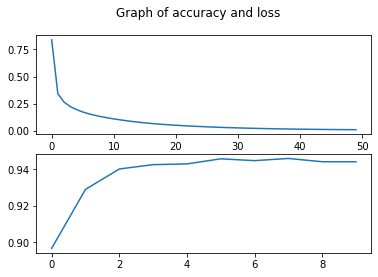

In [25]:
# Initialize my network
my_network = [28*28, 128, 10]
activation_functions = [None, 'tanh', 'softmax']
number_epochs = 50
lr = 0.01
# Initialize weights and biais of my_network
W, B = init_params(my_network)

# training
start_time = time.time()
losses = []
accuracies = []
for epoch in range(number_epochs):
    epoch_losses = np.array([])
    start_epoch_time = time.time()
    for i in range(len(train_labels)):
        # prepare the input image
        X = flatten(train_images[i])
        X = X.reshape(len(X), 1)
        Y = one_hot(train_labels[i])
        # forward-propagation
        Z, A = forward_pass(X, W, B)
        loss = categoricalCrossEntropy(A[-1], Y)
        epoch_losses = np.concatenate([epoch_losses, loss])
# example of neural network architecture that helps to understand my notation:
        # 28*28 ---->| 128          --->| 20           --->| 10
        # A[0] ----->| {Z[0], A[1]} --->| {Z[1], A[2]} --->| {Z[2], A[3]}
        # ---------->| {W[0], B[0]} --->| {W[1], B[1]} --->| {W[2], B[2]}
        # 1st_layer->| 1st_h_layer  --->| 2nd_h_layer  --->| outpyt_layer

# example of functions :
        # A[0] = input_layer = X
        # Z[t] = W[t] @ A[t] + B[t]    ---------> '@' means produit matriciel
        # A[t] = act_func(Z[t-1])
        

        # backpropagation
        dL_dZ2 = A[-1] - Y
        dL_dW, dL_dB, dL_dZ = [], [], [dL_dZ2]
        # here the variable indice has for aim to keep truck to which layer are we
        # and the variable indx_act_func has the objectif to tell us which activation function should we use in each layer
        indice, indx_act_func = 0, -1
        for layer in range(len(my_network)-1):
          dl_dw, dl_db, dl_dz = backpro_pass(dL_dZ[-1], A, Z, W, indice - 2, indx_act_func)
          dL_dW.append(dl_dw)
          dL_dB.append(dl_db)
          dL_dZ.append(dl_dz)
          indice = indice - 1 
          indx_act_func = indx_act_func - 1
          
        # update weights W and Biais B  
        dL_dW.reverse()
        dL_dB.reverse()
        W, B = update_W_and_B(W, dL_dW, B, dL_dB, lr)
      
    # Test my model at epoch = gama    
    if (epoch % 5 == 0):
        accuracy = compute_accuracy(val_images, val_labels, W, B)
        accuracies.append(accuracy)
        print('---------------------------------------------------------------------------> Accuracy : ',accuracies[-1])

    print('epoch ',epoch,' -------> loss : ',np.array(epoch_losses).mean(), ' | time : ',(time.time() - start_epoch_time))
    losses.append(np.array(epoch_losses).mean())

print("--- %s seconds ---" % (time.time() - start_time), ' | time : ',(time.time() - start_time)) 
fig, ax = plt.subplots(2)
fig.suptitle('Graph of accuracy and loss')
ax[0].plot(losses)
ax[1].plot(accuracies)

In [26]:
show_accuracies(train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B)

Accuracies :
    - train accuracy = 99.69333333333333 %
    - val accuracy = 94.44 %
    - test accuracy = 93.78 %
